In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
#load walker weights and progress coordinates from west.h5 file

def load_h5_pc_data(abspath, date_time, miniter=0, maxiter=-1, include_last_round=False):

    #---------------------------------------------------
    #load westpa output file

    with h5py.File(f'{abspath}/west{date_time}.h5', 'r') as f:

        iter_data = [iter for iter in f["iterations"]]

        if maxiter == -1:
            if include_last_round:
                maxiter = len(iter_data)
            else:
                maxiter = len(iter_data) - 1

        #note that the number of containing arrays is sensitive to 
        #whether the data is extracted by indexing or list comprehension
        pcoord_ndim = len(f["iterations"][f'iter_{str(miniter+1).zfill(8)}']['pcoord'][0][0])

        #this could be done by another layer of list comprehension but this is more readable
        pcoords = []
        for pcd in range(pcoord_ndim):
            pcoords.append([[i[0][pcd] for i in f["iterations"][f'iter_{str(i+1).zfill(8)}']['pcoord']] for i in range(miniter, maxiter)])

        iters = [[i for j in range(len(pcoords[0][i-miniter]))] for i in range(miniter, maxiter)]
        weights = [[i[0] for i in f["iterations"][f'iter_{str(i+1).zfill(8)}']["seg_index"]] for i in range(miniter, maxiter)]

    print(f"loading westpa iterations {miniter+1} to {maxiter}")

    #---------------------------------------------------
    #make flattened list versions

    pcoords_flat = [[j for i in pcoords[pcd] for j in i ] for pcd in range(pcoord_ndim)]
    iters_flat   = [j for i in iters for j in i ]
    weights_flat = [j for i in weights for j in i ]    
    
    return pcoords_flat, iters_flat, weights_flat, maxiter, pcoords, weights


In [3]:
#convert populations to relative free energies and large constants where there's no sampling

def pops_2_fe(populations):
    
    real_log = lambda x: -np.log(x) if x != 0 else 9999

    relative_fe_t = np.zeros(populations.shape) #hist2d_pc1_pc2[0]

    for i in range(populations.shape[0]):
        for j in range(populations.shape[1]):
            relative_fe_t[i][j]=real_log(populations[i][j])

    relative_fe = np.rot90(relative_fe_t)
    
    #plt.matshow(relative_fe)
    
    return relative_fe

In [4]:
#see the following stackoverfow posts: 
# https://stackoverflow.com/questions/22548813/python-color-map-but-with-all-zero-values-mapped-to-black
# https://stackoverflow.com/questions/56062299/how-to-add-axis-labels-to-imshow-plots-in-python
# https://stackoverflow.com/questions/13384653/imshow-extent-and-aspect

def plot_masked_energies(relative_fe, xlims, ylims, plot_size, aspect_ratio, labels):

    # mask 'bad' regions with no sampling
    masked_rfe = np.ma.masked_where(relative_fe == 9999, relative_fe)

    #set color mapping for regions with sampling
    cmap = mpl.colormaps.get_cmap("viridis").copy()

    #set color for 'bad' regions with no sampling
    cmap.set_bad(color='grey')

    imshow_scale_constant = 2.9
    pltx = plot_size*imshow_scale_constant
    plty = plot_size*imshow_scale_constant
    plt.figure(figsize=(pltx,plty))
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    im = plt.imshow(masked_rfe, interpolation='none', cmap=cmap, extent = [xlims[0], xlims[1], ylims[0], ylims[1]], aspect = aspect_ratio, vmax=25)
    plt.show()

In [5]:
def old_free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle):
    #calculate and plot free energies
    relative_fe = pops_2_fe(populations)
    
    #plot free energies for last round
    print(relative_fe.shape)
    relative_fe_x = []
    relative_fe_y = []
    relative_fe_y_std = []

    #loop over bins
    for i in range(relative_fe.shape[1]):

        relative_fe_x.append(i*(xlims[1]-xlims[0])/relative_fe.shape[1] + xlims[0])
        
        round_relative_fe_y = []

        #loop over rounds
        for j in range(n_rounds_to_average):
            if relative_fe[j][i] < 9999:
                round_relative_fe_y.append(relative_fe[j][i])

        relative_fe_y.append(np.mean(round_relative_fe_y))
        relative_fe_y_std.append(np.std(round_relative_fe_y))

    #plt.errorbar(relative_fe_x,relative_fe_y, yerr=relative_fe_y_std)
    plt.plot(relative_fe_x,relative_fe_y)
    plt.xlim(xlims[0], xlims[1])
    #plt.xlim(0.25,1)

    plt.xlabel(labels[0])
    #plt.xlabel("water wire maximum gap length (nm)")
    plt.ylabel("free energy (kT)")
    
    plt.savefig(plottitle)
    plt.show()
    
    plot_masked_energies(relative_fe, xlims, ylims, plot_size, aspect_ratio, labels)

    return relative_fe_x, relative_fe_y

In [6]:
def free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle):
    relative_fe = pops_2_fe(populations)
    plot_masked_energies(relative_fe, xlims, ylims, plot_size, aspect_ratio, labels)


In [7]:
#calculate and plot free energies
def plot_average_fe(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle):

    print(populations.shape)
    pops_mean = np.mean(populations, axis=1)

    x = []
    energies = []

    for i, p in enumerate(pops_mean):
        if p != 0:
            x.append(i*(xlims[1]-xlims[0])/pops_mean.shape[0] + xlims[0])
            energies.append(-np.log(p))
            
    plt.plot(x, energies)
    plt.xlabel(labels[0])
    plt.ylabel("free energy (kT)")
    plt.show()

    return x, energies


In [8]:
    
def populations_by_round(
    data, 
    weights, 
    limits = ((0, 1), (0, 1)), 
    #bins = ([0,1,2], [0,1,2]),
    labels = ("distance from binding site", "westpa round"), 
    bin_densities = [10,2], 
    transpose = False, 
    plot_size = 6,
    aspect_ratio = 0.03):

    #----------------------------------------------
    # input : axis mapping; more convenient than manually switching all the different arguments
    
    if not transpose:
        invlist = [0,1]
    else:
        invlist = [1,0]
        aspect_ratio = 1/aspect_ratio
       
    xlims = limits[invlist[0]]
    xlabel = labels[invlist[0]]
    xvals = data[invlist[0]]
    x_bin_densities = bin_densities[invlist[0]]

    ylims = limits[invlist[1]]
    ylabel = labels[invlist[1]]
    yvals = data[invlist[1]]
    y_bin_densities = bin_densities[invlist[1]]

    #----------------------------------------------
    #plotting parameters
    
    #set numbers of x and y bins using a constant bin density per nanometer
    pcx_bins = round((xlims[1]-xlims[0])*x_bin_densities)
    pcy_bins = round((ylims[1]-ylims[0])*y_bin_densities)
    # pcx_bins = bins[0]
    # pcy_bins = bins[1]
    
    #set plot size using a constant screen length per nanometer
    sizeconstant_x = plot_size
    sizeconstant_y = plot_size*aspect_ratio
    pltx = sizeconstant_x*(xlims[1]-xlims[0])
    plty = sizeconstant_y*(ylims[1]-ylims[0])

    #----------------------------------------------
    #bin and plot data using plt.histogram

    plt.figure(figsize=(pltx,plty))

    hist2d_pc1_pc2 = plt.hist2d(x=xvals, y=yvals, weights=weights, range=(xlims,ylims), bins=(pcx_bins, pcy_bins))
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    #plt.title("water wire length distribution by westpa round")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.savefig("we08-2d-fe-axis-template")
    plt.show()
        
    #return histogram coordinate limits and populations
    return xlims, ylims, hist2d_pc1_pc2[0]


In [9]:
def probability_below_threshold(pcoords, weights, threshold, n_rounds_to_average):
    p_below_by_round = []
    
    outer_ind = 0
    
    for pcs, ws in zip(pcoords[outer_ind], weights):
        p_below_by_round.append(sum([p*w for p,w in zip(pcs,ws) if p<threshold]))
        
    p_average = []
    for j in range(n_rounds_to_average, len(p_below_by_round), n_rounds_to_average):
        p_average.append(np.mean(p_below_by_round[j-n_rounds_to_average : j]))
        
    return p_average

# Run plotting methods

### various westpa runs

loading westpa iterations 1 to 2000


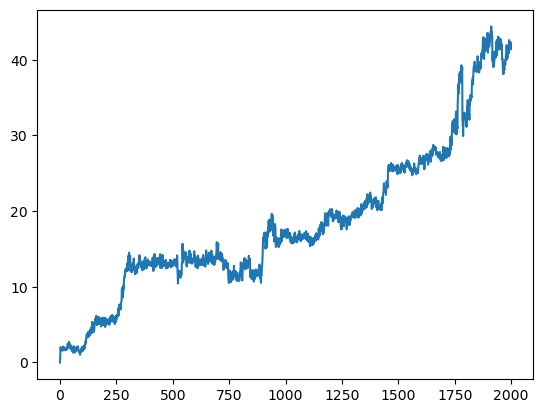

1912
loading westpa iterations 1 to 1000


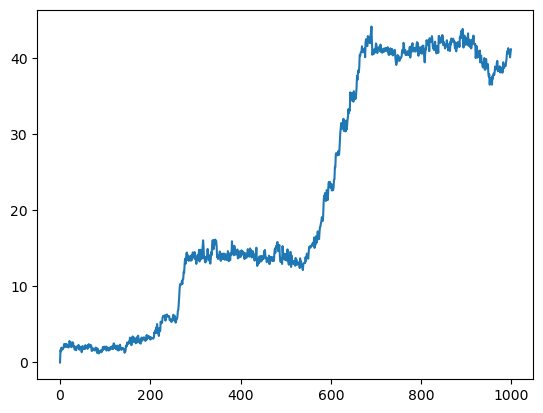

690
loading westpa iterations 1 to 2000


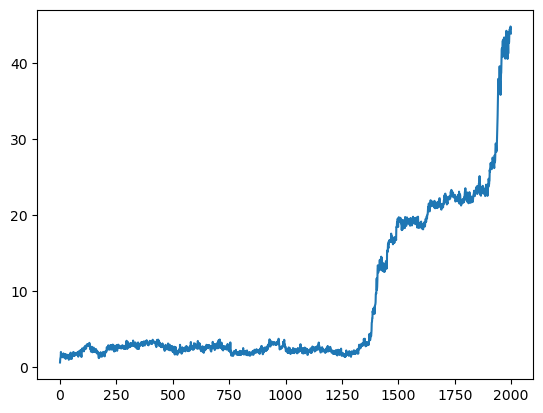

1997
loading westpa iterations 1 to 2000


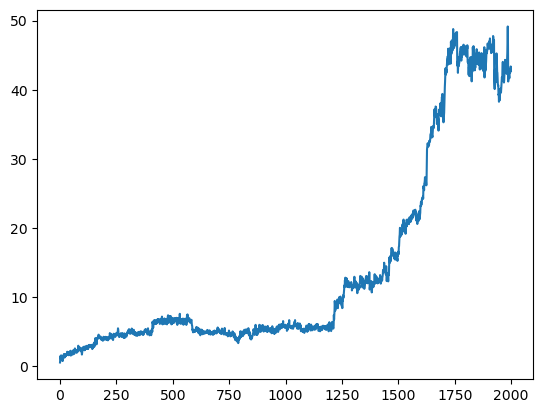

1985


In [23]:
#load data
#each entry is [abspath, date_time, miniter, maxiter]
path_h5date = [
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we28d8", "-060324-1622", 0, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we28d9", "-060324-1622", 0, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we50", "-101324-1524", 514, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we51", "-101324-1525", 509, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we37", "-101324-0816", 0, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/we43", "-101324-2009", 0, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/aac1/trajectories/we54", "-120524-1138", 0, -1],
    ["/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/aac1/trajectories/we55", "-121424-1123", 0, -1],
    ["/home/jonathan/Documents/grabelab/aac1-ucp1/aac1/trajectories/we57", "-010925-1219", 0, -1],
    ["/home/jonathan/Documents/grabelab/aac1-ucp1/aac1/trajectories/we58", "-011325-1053", 0, -1],
    ["/home/jonathan/Documents/grabelab/aac1-ucp1/aac1/trajectories/we61", "-020325-0941", 0, -1],
    ["/home/jonathan/Documents/grabelab/aac1-ucp1/aac1/trajectories/we62", "-012825-1036", 0, -1],
    ["/home/jonathan/Documents/grabelab/cftr/ligand-simulations/nonlipidated/westpa/westpa-63", "-041525-1055", 0, -1],
    ["/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_cftr_1_degrabo", "-051325", 0, 2000, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
    ["/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_cftr_2_wynton",  "-051425",  0, 1000, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
    ["/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_lip_glpg_1",     "-040925", 0, 2000, [0, 1, 3, 5, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
    ["/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_lip_glpg_2",     "-040925", 0, 2000, [0,1,1.3,1.5,1.7,2,2.2,2.4,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25.5,26,26.5,27,28,29,30,32,34,36,38,40,41,50]]]

# #can we make this read in the bounds from a west.cfg file?
# h5paths_names = [ [f"{cftr_west}/wstp_cftr_1_degrabo/west-040925.h5", f"{cftr_refpc}/nonlip_glpg_1", "pyrazole-1",  "blue",   ],
#                   [f"{cftr_west}/wstp_cftr_2_wynton/west-040925.h5",  f"{cftr_refpc}/nonlip_glpg_2", "pyrazole-2",  "cyan",   ],
#                   [f"{cftr_west}/wstp_lip_glpg_1/west-040925.h5",     f"{cftr_refpc}/lip_glpg_1",    "undecanol-1", "red",    ],
#                   [f"{cftr_west}/wstp_lip_glpg_2/west-040925.h5",     f"{cftr_refpc}/lip_glpg_2",    "undecanol-2", "orange", ]
# ]

fe_x_all = []
fe_y_all = []

for we_index in [-4,-3,-2,-1]: #
    #we_index = -4
    
    abspath = path_h5date[we_index][0]
    date_time = path_h5date[we_index][1]
    
    miniter = path_h5date[we_index][2]
    maxiter = path_h5date[we_index][3]
    include_last_round=False
    we_bins = path_h5date[we_index][4]
    
    pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)
    #print([max(pc) for pc in pcoords[0]])
    plt.plot([max(pc) for pc in pcoords[0]])
    plt.show()

    print(np.argmax([max(pc) for pc in pcoords[0]]))

    continue
    #---------------------------------------------------------
    #plot populations
    
    print("plotting populations")
    
    #parameters
    data = (pcoords_flat[0], iters_flat)
    limits = ((0, 50), (miniter, maxiter_value))
    labels = ("maximum water wire gap (nm)", "westpa round")
    bin_densities = [2,1] #if the data have units, the units of density are the reciprocal of the data units
    transpose = False
    plot_size = 6
    aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition
    
    #argument line 1 = data
    #argument line 2 = histogram parameters and labels
    #argument line 3 = plot size and scale parameters
    xlims, ylims, populations = populations_by_round(
        data, 
        weights_flat,
        limits, 
        labels, 
        bin_densities, 
        transpose, 
        plot_size, 
        aspect_ratio)
    
    
    #---------------------------------------------------------
    #plot free energies
    
    #xlims = (0,1)
    
    print("plotting free energies")
    
    n_rounds_to_average = 15
    plottitle = f"{abspath}/{abspath.split('/')[-1]}_WE_energy_vs_connectivity"
    free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)
    fe_x, fe_y = plot_average_fe(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)
    fe_x_all.append(fe_x)
    fe_y_all.append(fe_y)


for fxa, fya in zip(fe_x_all, fe_y_all):
    plt.plot(fxa, fya)
    #plt.xlim(0,10)
    # #---------------------------------------------------------
    # #plot probability below threshold
    
    # pbt = probability_below_threshold(pcoords, weights, 5, n_rounds_to_average)
    
    # plt.plot(pbt)
    # #plt.yscale('log')
    # plt.xlabel("westpa round")
    # plt.ylabel("water wire probability")
    # plt.savefig(f"{abspath}/{abspath.split('/')[-1]}_WE_probability_vs_round")


In [18]:
len(pcoords[0][0])

216

In [11]:
#x axis: ligand center of mass distance from bound pose (A)
#y axis: free energy (kT)


In [12]:
#weights[5]

In [13]:
#plt.hist(weights[-1])

In [14]:
len(weights[-1])

224

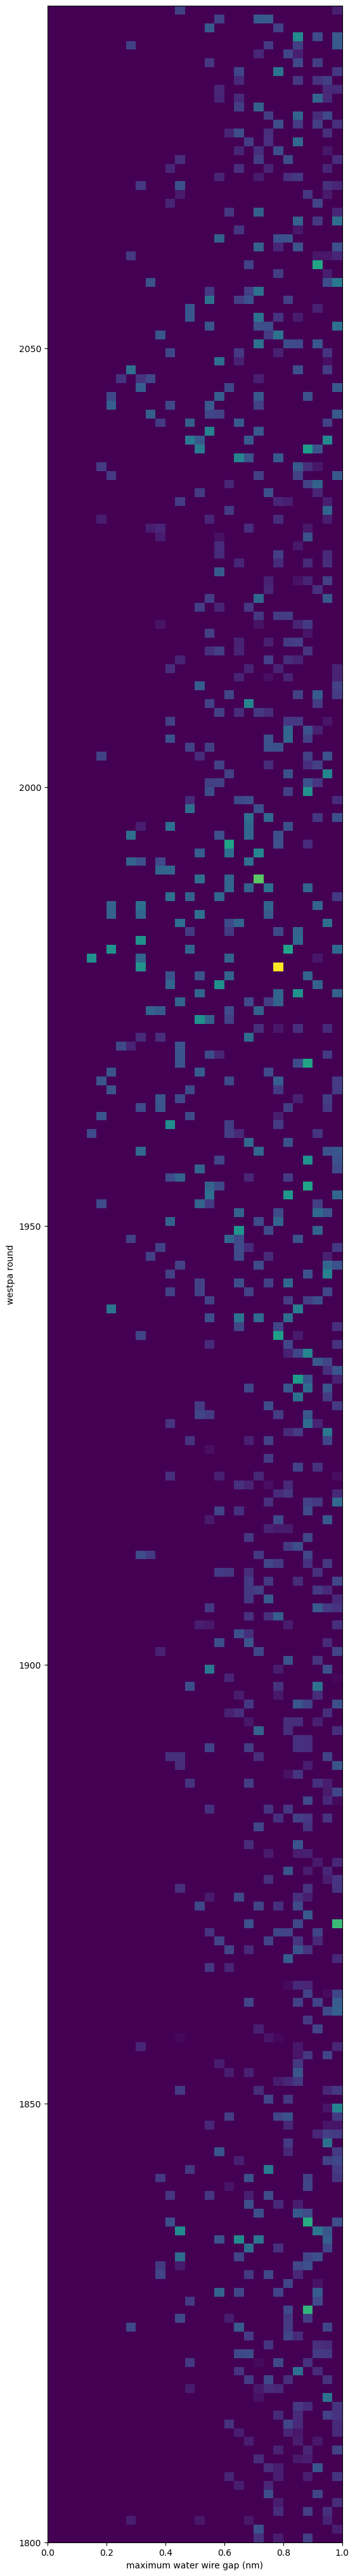

In [15]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights_flat,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)

In [16]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

TypeError: free_energies_by_round() missing 2 required positional arguments: 'labels' and 'plottitle'

In [ ]:
#plot probability below threshold

pbs = probability_below_threshold(pcoords, weights, .33)
plt.plot(pbs)
plt.yscale('log')

In [ ]:
plt.plot([max(i) for i in weights])
plt.show()
plt.plot([min(i) for i in weights])
plt.yscale("log")
plt.show()
plt.plot([np.median(i) for i in weights])
plt.yscale("log")
plt.show()

### we45

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/aac1/trajectories/we45" #"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we37"
date_time = '-091724-1240' #'080924-1402' #'051324-0800'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1.2), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [40,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights, 
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)

In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

### we46

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/aac1/trajectories/we46"
#"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/aac1/trajectories/we46"
#"/home/jonathan/grabelab/aac1-ucp1/aac1/trajectories/we46" 
date_time = '-092524-1137' #'-091924-1004' #'080924-1402' #'051324-0800'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1.2), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [40,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights, 
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)

In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

## Chloe data

### wstp_cftr_1_degrabo

In [ ]:
#load data

abspath = "/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_lip_glpg_1" 
date_time = '-030425'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
import random
bins = np.arange(0,50,1)
print(f"bins: {bins}")
data_bins = np.digitize(pcoords_flat, bins)[0]
binned_data = [[i for i,b in enumerate(data_bins) if b == bb+1] for bb in bins]
print([len(i) for i in binned_data])

n_walkers = 10
sampled_walkers = []

for b in binned_data:
    n_walkers_ = min(n_walkers, len(b))
    if n_walkers != 0:
        sampled_walkers.append(random.choices(b, k=n_walkers_))
    else:
        sampled_walkers.append([])

print(sampled_walkers)

In [ ]:
print(max([max(i) for i in pcoords_flat]))

In [ ]:
plt.plot([max(i) for i in weights])
plt.show()
plt.plot([min(i) for i in weights])
plt.yscale("log")
plt.show()
plt.plot([np.median(i) for i in weights])
plt.yscale("log")
plt.show()

In [ ]:
#plot probability below threshold

# pbs = probability_below_threshold(pcoords, weights, 1)
# plt.plot(pbs)
# plt.yscale('log')

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 45), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [1/2,1/2] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
#free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)
n_rounds_to_average = 10
plottitle=""
free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)


### wstp_cftr_2_wynton

In [ ]:
#load data

abspath = "/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_cftr_2_wynton" #"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we37"
date_time = '-' #'080924-1402' #'051324-0800'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
print(max([max(i) for i in pcoords_flat]))

In [ ]:
plt.plot([max(i) for i in weights])
plt.show()
plt.plot([min(i) for i in weights])
plt.yscale("log")
plt.show()
plt.plot([np.median(i) for i in weights])
plt.yscale("log")
plt.show()

In [ ]:
#plot probability below threshold

pbs = probability_below_threshold(pcoords, weights, 1)
plt.plot(pbs)
plt.yscale('log')

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 45), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [1,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
n_rounds_to_average = 10
plottitle=""
free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)

### wstp_lip_glpg_1

In [ ]:
#load data

abspath = "/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_lip_glpg_1" #"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we37"
date_time = '-' #'080924-1402' #'051324-0800'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 45), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [1,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
n_rounds_to_average = 10
plottitle=""
free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)

### wstp_lip_glpg_2

In [ ]:
#load data

abspath = "/home/jonathan/Documents/grabelab/cftr/chloe-data/wstp_lip_glpg_2" #"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we37"
date_time = '-continued' #'080924-1402' #'051324-0800'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 45), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [1,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
n_rounds_to_average = 10
plottitle=""
free_energies_by_round(xlims, ylims, populations, n_rounds_to_average, plot_size, aspect_ratio, labels, plottitle)

## we43

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/ucp1/trajectories/we43"
date_time = '-090624-1521'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
if False:
    plt.plot([max(i) for i in weights])
    plt.show()
    plt.plot([min(i) for i in weights])
    plt.yscale("log")
    plt.show()
    plt.plot([np.median(i) for i in weights])
    plt.yscale("log")
    plt.show()

In [ ]:
#plot probability below threshold

pbt = probability_below_threshold(pcoords, weights, .33)
plt.plot(pbt)
plt.yscale('log')
plt.ylim(10**-12, 1)
print(np.mean(pbt))
plt.xlabel("WE round")
plt.ylabel("water wire formation probability")
plt.savefig("we43-UCP1-GTP-water-wire-formation-probability-WE")

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

## we38

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/ucp1/trajectories/we38"
date_time = '-072224-1558'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
if False:
    plt.plot([max(i) for i in weights])
    plt.show()
    plt.plot([min(i) for i in weights])
    plt.yscale("log")
    plt.show()
    plt.plot([np.median(i) for i in weights])
    plt.yscale("log")
    plt.show()

In [ ]:
#plot probability below threshold

pbt = probability_below_threshold(pcoords, weights, .33)
print(np.mean(pbt))

plt.plot(pbt)
plt.yscale('log')
plt.ylim(10**-12, 1)

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

## we37

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/ucp1/trajectories/we37"
date_time = '-080924-1402'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
if False:
    plt.plot([max(i) for i in weights])
    plt.show()
    plt.plot([min(i) for i in weights])
    plt.yscale("log")
    plt.show()
    plt.plot([np.median(i) for i in weights])
    plt.yscale("log")
    plt.show()

In [ ]:
#plot probability below threshold

pbt = probability_below_threshold(pcoords, weights, .33)
print(np.mean(pbt))

plt.plot(pbt)
plt.yscale('log')
plt.ylim(10**-12, 1)
plt.xlabel("WE round")
plt.ylabel("water wire formation probability")
plt.savefig("we37-UCP1-DNP-water-wire-formation-probability-WE")

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

## We28-series 

### we28d9

In [ ]:
#load data

abspath = "/home/jonathan/grabelab/aac1-ucp1/ucp1/trajectories/we28d9"
#"/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we28d9"
date_time = '-072924-1411'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
plt.plot([max(i) for i in weights])
plt.show()
plt.plot([min(i) for i in weights])
plt.yscale("log")
plt.show()
plt.plot([np.median(i) for i in weights])
plt.yscale("log")
plt.show()

In [ ]:
#plot probability below threshold

pbs = probability_below_threshold(pcoords, weights, .33)
plt.plot(pbs)
plt.yscale('log')

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

### we28d8

In [ ]:
#load data

abspath = "/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we28d8"
date_time = '-050824-1055'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot probability below threshold

pbs = probability_below_threshold(pcoords, weights, .33)
plt.plot(pbs)
plt.yscale('log')

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap (nm)", "westpa round")
bin_densities = [133,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

### we28d7

In [ ]:
#load data

abspath = "/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we28d7"
date_time = '042624-1339' #'042524-2319'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio)

## We33

In [ ]:
#load data

# abspath = "/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/aac1/trajectories/we35"
# date_time = '060824-2156'

abspath = "/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/aac1/trajectories/we18"
date_time = '111923-2221'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((0, 1), (miniter, maxiter_value))
labels = ("maximum water wire gap", "westpa round")
bin_densities = [30,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

# we21

In [ ]:
#load data

abspath = "/Users/jonathanborowsky/Documents/grabelab/aac1-ucp1/ucp1/trajectories/bound-dnp/we21"
date_time = '060824-2043'

miniter=0
maxiter=-1
include_last_round=False

pcoords_flat, iters_flat, weights_flat, maxiter_value, pcoords, weights = load_h5_pc_data(abspath, date_time, miniter, maxiter, include_last_round)


In [ ]:
#plot probability below threshold

pbs = probability_below_threshold(pcoords, weights, .33)
plt.plot(pbs)
plt.yscale('log')

In [ ]:
#plot populations

#parameters
data = (pcoords_flat[0], iters_flat)
weights = weights_flat
limits = ((-1, 1), (miniter, maxiter_value))
labels = ("DNP z distance from protein center of mass (nm)", "westpa round")
bin_densities = [100,1] #if the data have units, the units of density are the reciprocal of the data units
transpose = False
plot_size = 6
aspect_ratio = 0.03 #automatically raised to the -1st power upon transposition

#argument line 1 = data
#argument line 2 = histogram parameters and labels
#argument line 3 = plot size and scale parameters
xlims, ylims, populations = populations_by_round(
    data, 
    weights,
    limits, 
    labels, 
    bin_densities, 
    transpose, 
    plot_size, 
    aspect_ratio)


In [ ]:
free_energies_by_round(xlims, ylims, populations, plot_size, aspect_ratio, labels)

In [ ]:
pcoords_flat